# context effect space subsampling

in this pseudoexperiment I test how increasing the samplesd context effect space (number of probes and or contexts)
affect the frequency, amplitude and duration of contextual effects.

This is achieved by randomly selecting a subset of te stimuli used as contexta and or probes
and looking at the number of instances (cell * context * probe) with significant effects and the mean amplitude and
duration of said effects.

In [1]:
from pathlib import Path
import itertools as itt

import joblib as jl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import pandas as pd
import seaborn as sns
from IPython.display import display
from statannot import add_stat_annotation
from cycler import cycler

from src.data.region_map import region_map
from src.metrics.consolidated_dprimes import _load_site_formated_raste, single_cell_dprimes, full_dPCA_dprimes
from src.data.dPCA import _cpp_dPCA, format_raster
from src.visualization.fancy_plots import _raster, unit_line, savefig
from src.metrics.significance import _significance
from src.metrics.dprime import flip_dprimes
from src.metrics.reliability import signal_reliability
from src.data.rasters import raster_from_sig
from src.data.load import load

[nems.configs.defaults INFO] Saving log messages to /tmp/nems\NEMS 2021-04-14 101108.log
[numexpr.utils INFO] NumExpr defaulting to 4 threads.


In [2]:
#general plottin formating
plt.style.use('dark_background')
light_color_cycle = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
trans_color_map = {'silence': '#377eb8',  # blue
                   'continuous': '#ff7f00',  # orange
                   'similar': '#4daf4a',  # green
                   'sharp': '#a65628'}  # brown
params = {'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': light_color_cycle,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [4,4],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial',
          'legend.loc': 'upper right',
          'legend.frameon': False,
          'legend.fontsize': 15,
          'legend.markerscale': 3,
          }
widescreen = [13.3, 7.5]
plt.rcParams.update(params)

In [3]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path(f'../data/210302_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

In [4]:
dim_reduction = 'pdPCA'

# no need for means or mean policy, working on permutations only
ff_probe = DF.probe != 'mean'
ff_pairs = DF.context_pair != 'mean'
ff_stim = DF.stim_type == 'permutations'
ff_mean = DF.mean_signif_type == 'shuffles'

ff_analylis = DF.analysis.isin(['SC', dim_reduction])
ff_corr = DF.mult_comp_corr == 'consecutive_3'
ff_metric = DF.metric.isin(['significant_abs_mass_center', 'significant_abs_sum'])

good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
            'probe', 'metric', 'value']
filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr & ff_metric, good_cols]

# rename metrics and analysis for ease of ploting
filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                 'significant_abs_sum': "integral (d'*ms)"})
filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                     dim_reduction: 'population'})

filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
filtered = filtered.drop(columns=['cellid', 'siteid'])

filtered['value'] = filtered['value'].fillna(value=0)

# creates a new column relating probe with  context pairs
ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
prb = np.asarray(filtered.probe, dtype=int)

silence = ctx == 0
same = ctx == prb[:,None]
different = np.logical_and(~silence, ~same)

name_arr = np.full_like(ctx, np.nan, dtype=object)
name_arr[silence] = 'silence'
name_arr[same] = 'same'
name_arr[different] = 'diff'
comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

# swaps clasification names to not have repetitions i.e. diff_same == same_diff
comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'
comp_name_arr[np.where(comp_name_arr == 'diff_silence')] = 'silence_diff'
comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'

filtered['trans_pair'] = comp_name_arr

ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()

full_long = filtered

In [5]:
def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)

def nonan_proportion(arr):
    return np.sum(~np.isnan(arr))/arr.size * 100

def signif_proportion(arr):
    return np.sum(arr>0) / np.size(arr) * 100

# systematic subsampling of contexts and probes

Iterates over each contexts or probe subsampling, considering all possible combinations for each subsampling.
Counts the number definese the number of sigificant isntances. then storese in a dataframe with specific subsamples as
indices.

In [6]:
# filteres dataframe and adds required columns
filtered = pivoted.loc[pivoted.analysis=='single cell', :]
filtered['site'] = filtered.id.apply(lambda x: x[:7])

ctx_pairs = [pair.split('_') for pair in filtered.context_pair]
ctx_pairs = np.stack(ctx_pairs, axis=0)
filtered['ctx_0'] = ctx_pairs[:, 0]
filtered['ctx_1'] = ctx_pairs[:, 1]

# function to aggregate each single cell. gives the proportion of significant instances
agg_funcs = {"signif_proportion": ("integral (d'*ms)", signif_proportion)}


<ipython-input-6-20db8b69664d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['site'] = filtered.id.apply(lambda x: x[:7])
<ipython-input-6-20db8b69664d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['ctx_0'] = ctx_pairs[:, 0]
<ipython-input-6-20db8b69664d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [7]:
# iterates over all sizes of probe subsampling, i.e. 1, 2, 3 and 4 probes.
all_probes = filtered.probe.sort_values().unique()
prb_subsamp_signif = pd.DataFrame()

for num_probe in range(len(all_probes)):
    num_probe += 1

    n_probe_groups  = list(itt.combinations(all_probes, num_probe))
    # iterates over all possible combinations of n probes
    for pg, probe_group in enumerate(n_probe_groups):
        probes_df = filtered.loc[filtered.probe.isin(probe_group), :].set_index('region', 'site', 'id')
        grouped  = probes_df.groupby(['region', 'site', 'id']).agg(**agg_funcs).copy()
        grouped.loc[grouped.signif_proportion == 0] = np.nan
        grouped['n_probes'] = num_probe
        grouped['prb_group'] = '_'.join(probe_group)
        prb_subsamp_signif = prb_subsamp_signif.append(grouped.reset_index())

In [8]:
# iterates over all sizes of context subsampling, i.e. 2, 3, 4 and 5 contexts.
all_contexts = np.unique(ctx_pairs)
ctx_subsamp_signif = pd.DataFrame()

for num_ctx in range(2, len(all_contexts)+1):
    n_ctx_groups  = list(itt.combinations(all_contexts, num_ctx))
    # iterates over all possible combinations of n probes
    for cg, ctx_group in enumerate(n_ctx_groups):
        ctx_df = filtered.loc[(filtered.ctx_0.isin(ctx_group)) &
                                 ((filtered.ctx_1.isin(ctx_group))), :].set_index('region', 'site', 'id')
        grouped  = ctx_df.groupby(['region', 'site', 'id']).agg(**agg_funcs).copy()
        grouped.loc[grouped.signif_proportion == 0] = np.nan
        grouped['n_contexts'] = num_ctx
        grouped['ctx_group'] = '_'.join(ctx_group)
        ctx_subsamp_signif = ctx_subsamp_signif.append(grouped.reset_index())

In [9]:
# probes
display(ctx_subsamp_signif)

,region,site,id,signif_proportion,n_contexts,ctx_group
0,A1,AMT020a,AMT020a-02-1,NaN,2,0_1
1,A1,AMT020a,AMT020a-04-1,NaN,2,0_1
2,A1,AMT020a,AMT020a-07-1,NaN,2,0_1
3,A1,AMT020a,AMT020a-08-1,25.0,2,0_1
4,A1,AMT020a,AMT020a-13-1,NaN,2,0_1
...,...,...,...,...,...,...
857,PEG,CRD014b,CRD014b-24-2,7.5,5,0_1_2_3_4
858,PEG,CRD014b,CRD014b-27-1,12.5,5,0_1_2_3_4
859,PEG,CRD014b,CRD014b-27-2,7.5,5,0_1_2_3_4
860,PEG,CRD014b,CRD014b-27-3,7.5,5,0_1_2_3_4


## Proportion of significant instances for individual cells
only looking at cells with at least one significant instance

Text(0.5, 0.98, 'Proportion of significant instances\nfor individual cells')

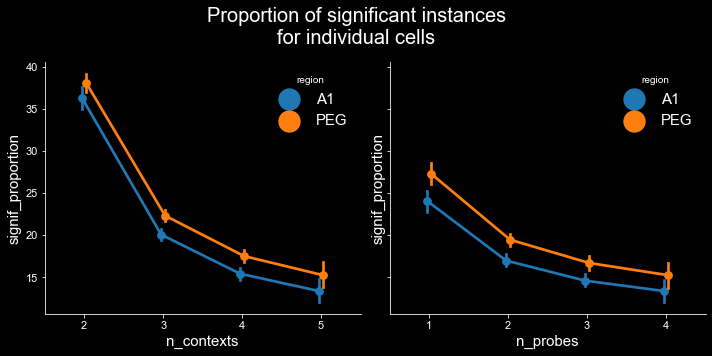

In [10]:
fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[10,5])
_ = sns.pointplot(x='n_contexts', y='signif_proportion', data=ctx_subsamp_signif, hue='region', dodge=True, ax=ctx_ax)
_ = sns.pointplot(x='n_probes', y='signif_proportion', data=prb_subsamp_signif, hue='region', dodge=True, ax=prb_ax)

fig.suptitle('Proportion of significant instances\nfor individual cells', fontsize=20)

## count of significant cells by site and or region

In [11]:
# collapses across neurons. Keeps information about region and ctx / prb subsamples.

ctx_count_by_site = ctx_subsamp_signif.set_index(['region','site', 'n_contexts','ctx_group']
                                     ).groupby(['region', 'site', 'n_contexts','ctx_group']
                                     ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)).reset_index()

prb_count_by_site = prb_subsamp_signif.set_index(['region','site', 'n_probes','prb_group']
                                     ).groupby(['region', 'site', 'n_probes','prb_group']
                                     ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)).reset_index()


In [12]:
# collapses across neurons, grouping by site. Keeps information about region and ctx / prb subsamples.

# ctx_count_by_site = ctx_subsamp_signif.set_index(['region','site', 'n_contexts','ctx_group']
#                                      ).groupby(['region', 'site', 'n_contexts','ctx_group']
#                                      ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)
#                                      ).groupby(['region', 'site', 'n_contexts']
#                                      ).agg(signfi_cell_prop=('signfi_cell_prop', np.nanmean)).reset_index()
#
# prb_count_by_site = prb_subsamp_signif.set_index(['region','site', 'n_probes','prb_group']
#                                      ).groupby(['region', 'site', 'n_probes','prb_group']
#                                      ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)
#                                      ).groupby(['region', 'site', 'n_probes']
#                                      ).agg(signfi_cell_prop=('signfi_cell_prop', np.nanmean)).reset_index()

Text(0.5, 0.98, 'count of significant cells\npers site')

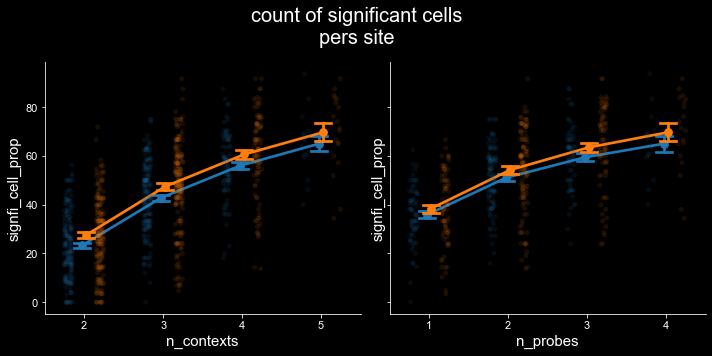

In [13]:
fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[10,5])
_ = sns.pointplot(x='n_contexts', y='signfi_cell_prop', hue='region', data=ctx_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=ctx_ax,)
_ = sns.stripplot(x='n_contexts', y='signfi_cell_prop', hue='region', data=ctx_count_by_site,
                  dodge=True, alpha=0.1, ax=ctx_ax)
ctx_ax.legend([],[], frameon=False)

_ = sns.pointplot(x='n_probes', y='signfi_cell_prop', hue='region', data=prb_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=prb_ax)
_ = sns.stripplot(x='n_probes', y='signfi_cell_prop', hue='region', data=prb_count_by_site,
                  dodge=True, alpha=0.1, ax=prb_ax)
prb_ax.legend([],[], frameon=False)

fig.suptitle('count of significant cells\npers site', fontsize=20)

# visualization of all cells in site
explore an option of showinge all cells vs all combinations of context_pair * probe for a given site

In [14]:
# cell_descriptio = filtered.pivot_table
# display(full_long)
pivot_ready = full_long.loc[full_long.analysis == 'single cell',
                            ['region', 'id', 'trans_pair', 'context_pair', 'probe', 'metric', 'value']]
pivot_ready['site'] = pivot_ready.id.apply(lambda x: x[:7])


summary = pivot_ready.pivot_table(values='value', index=['region', 'site', 'id'],
                                  columns=['metric', 'probe', 'trans_pair', 'context_pair'], fill_value=np.nan)

summary.index = summary.index.droplevel(0)
display(summary)

metric               center of mass (ms)                                       \
probe                                  1                                        
trans_pair                     diff_diff                       same_diff        
context_pair                         2_3        2_4        3_4       1_2  1_3   
site    id                                                                      
AMT020a AMT020a-02-1                 0.0   0.000000   0.000000       0.0  0.0   
        AMT020a-04-1                 0.0   0.000000   0.000000       0.0  0.0   
        AMT020a-07-1                 0.0   0.000000   0.000000       0.0  0.0   
        AMT020a-08-1                 0.0   0.000000   0.000000       0.0  0.0   
        AMT020a-13-1                 0.0   0.000000   0.000000       0.0  0.0   
...                                  ...        ...        ...       ...  ...   
CRD014b CRD014b-24-2                 0.0   0.000000   0.000000       0.0  0.0   
        CRD014b-27-1                 0.0   0.000000   0.000000       0.0  0.0   
        CRD014b-27-2                 0.0  32.521713  62.695485       0.0  0.0   
        CRD014b-27-3                 0.0   0.000000   0.000000       0.0  0.0   
        CRD014b-29-1                 0.0   0.000000   0.000000       0.0  0.0   

metric                                                                       \
probe                                                                         
trans_pair                silence_diff                         silence_same   
context_pair          1_4          0_2         0_3         0_4          0_1   
site    id                                                                    
AMT020a AMT020a-02-1  0.0     0.000000    0.000000    0.000000     0.000000   
        AMT020a-04-1  0.0     0.000000    0.000000    0.000000     0.000000   
        AMT020a-07-1  0.0     0.000000    0.000000    0.000000     0.000000   
        AMT020a-08-1  0.0     0.000000    0.000000    0.000000     0.000000   
        AMT020a-13-1  0.0     0.000000    0.000000    0.000000     0.000000   
...                   ...          ...         ...         ...          ...   
CRD014b CRD014b-24-2  0.0     0.000000    0.000000    0.000000     0.000000   
        CRD014b-27-1  0.0    32.557402    0.000000    0.000000    30.758933   
        CRD014b-27-2  0.0     0.000000    0.000000    0.000000     0.000000   
        CRD014b-27-3  0.0     0.000000    0.000000    0.000000     0.000000   
        CRD014b-29-1  0.0     0.000000  329.597729  303.670459   317.444265   

metric                ... integral (d'*ms)                                    \
probe                 ...                4                                     
trans_pair            ...        diff_diff                         same_diff   
context_pair          ...              1_2         1_3         2_3       1_4   
site    id            ...                                                      
AMT020a AMT020a-02-1  ...          0.00000    0.000000    0.000000       0.0   
        AMT020a-04-1  ...          0.00000    0.000000    0.000000       0.0   
        AMT020a-07-1  ...          0.00000    0.000000    0.000000       0.0   
        AMT020a-08-1  ...        135.52272    0.000000    0.000000       0.0   
        AMT020a-13-1  ...          0.00000    0.000000    0.000000       0.0   
...                   ...              ...         ...         ...       ...   
CRD014b CRD014b-24-2  ...          0.00000    0.000000    0.000000       0.0   
        CRD014b-27-1  ...          0.00000    0.000000    0.000000       0.0   
        CRD014b-27-2  ...          0.00000    0.000000    0.000000       0.0   
        CRD014b-27-3  ...          0.00000    0.000000    0.000000       0.0   
        CRD014b-29-1  ...          0.00000  137.251142  104.264086       0.0   

metric                                                               \
probe                                                                 
trans_pair     

<AxesSubplot:ylabel='id'>

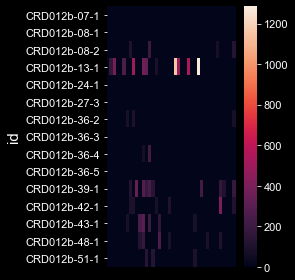

In [15]:
site = 'CRD012b'
# site = 'ARM021b'
site_eg = summary.loc[[site], ["integral (d'*ms)",]].droplevel(level=0, axis=0)
site_eg.columns = range(site_eg.shape[1])
site_eg
sns.heatmap(data=site_eg, xticklabels=False)

# is context or probes driving the diversity in contextual effects??

In [16]:
# display(filtered)

group_ready = filtered.set_index(['region', 'id', 'context_pair', 'trans_pair', 'probe'])
prb_diversity = group_ready.groupby(['region', 'id', 'context_pair']).agg(signif_proportion=("integral (d'*ms)", signif_proportion))
ctx_diversity = group_ready.groupby(['region', 'id', 'probe']).agg(signif_proportion=("integral (d'*ms)", signif_proportion))

In [17]:
# display(prb_diversity)
# display(ctx_diversity)
diversity = pd.concat([prb_diversity, ctx_diversity], axis=0,keys=['probe', 'context'],
                      names = ['diversity', 'region', 'id', 'sound_id'])

# take average diversity per cell
diversity.loc[diversity.signif_proportion == 0, ['signif_proportion']] = np.nan
diversity = diversity.groupby(['diversity', 'region', 'id']).agg(np.nanmean)
diversity.reset_index(inplace=True)
display(diversity)

,diversity,region,id,signif_proportion
0,probe,A1,AMT020a-02-1,25.000000
1,probe,A1,AMT020a-04-1,NaN
2,probe,A1,AMT020a-07-1,NaN
3,probe,A1,AMT020a-08-1,33.333333
4,probe,A1,AMT020a-13-1,NaN
...,...,...,...,...
1719,context,PEG,CRD014b-24-2,15.000000
1720,context,PEG,CRD014b-27-1,25.000000
1721,context,PEG,CRD014b-27-2,15.000000
1722,context,PEG,CRD014b-27-3,15.000000


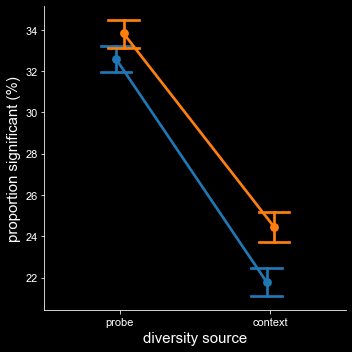

In [18]:
fig, ax = plt.subplots(figsize=(5,5))
# sns.stripplot(x='diversity', y='signif_proportion', hue='region', data=diversity,
#               dodge=True, alpha=0.1, ax=ax)
sns.pointplot(x='diversity', y='signif_proportion', hue='region', data=diversity,
              dodge=True, s=2, capsize=0.2, ci=68, ax=ax)

ax.legend([],[], frameon=False)
ax.set_xlabel('diversity source')
ax.set_ylabel('proportion significant (%)')
title = 'single cell diversity source'
savefig(fig, 'DAC4', title)